# Latvijas Universitātes Datorikas fakultātes
## Izstrādes kods bakalaura darbam: **Teksta sarežģītības novērtēšana latviešu valodai**
### Autors: *Māris Kalniņš* | 2024. gads
### Piezīme: Detalizētāka informācija kā kods strādā ir lasāms bakalaura darbā.

# 1. Moduļu importēšana

In [61]:
# Datu apstrādes moduļi
from google.colab import files          # Ielasīt failu
import joblib          # Lejupielādēt modeļa Pickle serializāciju priekš API izsaukumiem
import pandas as pd          # Darbs ar dokumenta tipa datiem
import re          # Regulārās izteiksmes interpretators
import requests          # Publiski pieejamas datnes saņemšana
import nltk          # Dabiskās valodas apstrādes rīks
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize          # Tekstvienību sadalīšana pa vārdiem un teikumiem
import numpy as np          # Darbs ar Numpy masīva datu struktūru

# Mašīnapmācīšanas moduļi
from sklearn.model_selection import train_test_split          # Datu sadalīšana apmācības un validācijas kopās
from sklearn.model_selection import GridSearchCV          # Hiperparametru regulēšana, izmantojot savstarpējo validāciju (cross-validation)
from sklearn.feature_extraction.text import TfidfVectorizer          # Teksta datu konvertēšanai TF-IDF funkcijās
from sklearn.pipeline import make_pipeline          # 'Pipeline' izveidošana, kas sastāv no skalārā un loģiskās regresijas modeļa
from sklearn.linear_model import LogisticRegression          # Loģistiskās regresijas klasifikatora izveide
from sklearn.metrics import accuracy_score          # Modeļa veiktspējas novērtēšana, izmantojot precizitātes rādītāju
from sklearn.model_selection import learning_curve          # Modeļa apmācību novērtēšana, izmantojot Learning Curve metodi (Treniņa rezultāti un savstarpējā validācija)

# Vizualizācija
import matplotlib.pyplot as plt          # Datu vizualizācijas rīks
from wordcloud import WordCloud          # Vizualizācija, kur katra vārda fonta lielums norāda tā biežumu vai nozīmi.
import seaborn as sns          # Teksta statistikas kortežu vizualizācija

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
!ls
uploaded = files.upload()

df = pd.read_excel('VISC_LATV_train.xlsx')
# Izmest ārā unnamed kolonnu
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

sample_data


Saving VISC_LATV_train.xlsx to VISC_LATV_train.xlsx


,Teksts,Klase,VISC m.g.
0,"Ticis Rīgā, zaķis uzmeklē sēklu tirgotavu. Ko...",3,2008/2009
1,"– Ak skābu kāpostu, – pavisam saldā balsī iesa...",3,2008/2009
2,Lauris iziet cauri nelielam krūmājam. Kājas sā...,3,2008/2009
3,Andra un Mārītes māmiņai bija lādīte ar saktām...,6,2008/2009
4,Divtūkstoš gadus pirms Kristus\ndzimšanas viļņ...,6,2008/2009
...,...,...,...
244,Mazo palmiņu atnesa mājās vasaras vidū un novi...,3,2017/2018
245,„Ko tu tā brīnies?” ierunājās dīvainā puķe. „E...,3,2017/2018
246,Bet tad kādu rītu logā iespīdēja spilgti saule...,3,2017/2018
247,Cilvēka pēda ir kā maza ķermeņa karte ar tūkst...,3,2017/2018


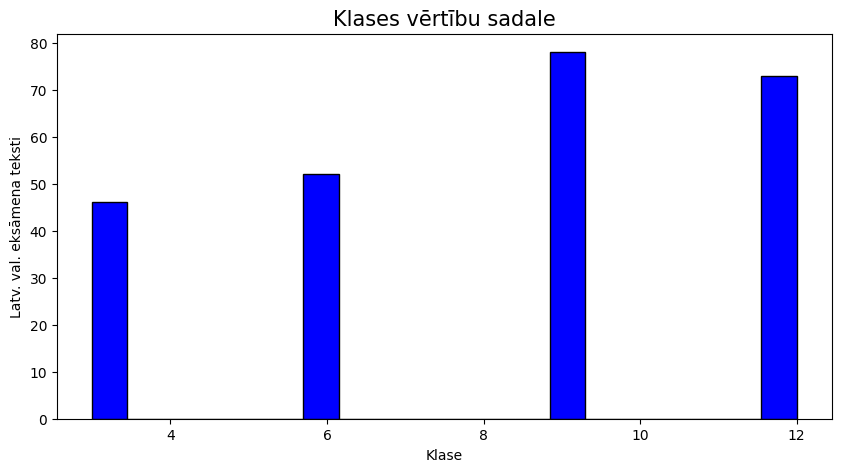

In [51]:
def plot_histogram(df_train, column, x_title=None, y_title=None, edge_color='black', color='blue', total_bins=20, font_size=10):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(df_train[column], bins=total_bins, edgecolor=edge_color, color=color)
    ax.set_title(f'{column}s vērtību sadale', fontsize=font_size + 5)
    ax.set_xlabel(column if x_title is None else x_title, fontsize=font_size)
    ax.set_ylabel(y_title if y_title is not None else "Latv. val. eksāmena teksti", fontsize=font_size)
    plt.show()

plot_histogram(df, 'Klase')

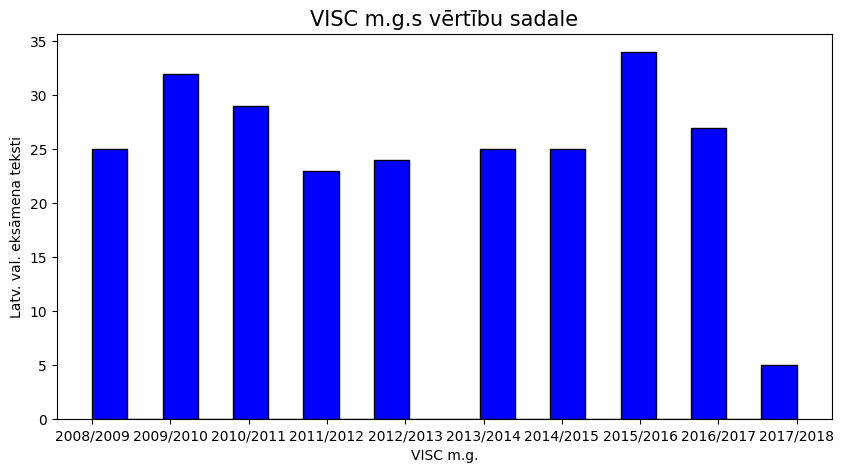

In [50]:
def plot_histogram(df, column, x_title=None, y_title=None, edge_color='black', color='blue', total_bins=20, font_size=10):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(df[column], bins=total_bins, edgecolor=edge_color, color=color)
    ax.set_title(f'{column}s vērtību sadale', fontsize=font_size + 5)
    ax.set_xlabel(column if x_title is None else x_title, fontsize=font_size)
    ax.set_ylabel(y_title if y_title is not None else "Latv. val. eksāmena teksti", fontsize=font_size)
    plt.show()

plot_histogram(df, 'VISC m.g.')

In [7]:
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-lv/master/stopwords-lv.json"
response = requests.get(stopwords_url)
lv_stopwords = response.json()
lv_stopwords.extend(["kas","tiem","visi","mana","kuras","savas","jūs","tas","nav","ko","cik","kad","kur","e","vēl","būtu","sevi","nekad","es","viņš","viņa","manu","savu","mēs","mūsu","viņu","tu","ļoti","man","viņas","sava","tur","kādu","tādu","mani","tās","visu","mums","daudz","nebija","viņa","kura","kuru","kurš","kāds","kāda","šī","viņai","tam","mana""tas","viņi","tie","vairs","viņam","savā","tev","šo","viss"])
print(lv_stopwords)

['aiz', 'ap', 'apakš', 'apakšpus', 'ar', 'arī', 'augšpus', 'bet', 'bez', 'bija', 'biji', 'biju', 'bijām', 'bijāt', 'būs', 'būsi', 'būsiet', 'būsim', 'būt', 'būšu', 'caur', 'diemžēl', 'diezin', 'droši', 'dēļ', 'esam', 'esat', 'esi', 'esmu', 'gan', 'gar', 'iekam', 'iekams', 'iekām', 'iekāms', 'iekš', 'iekšpus', 'ik', 'ir', 'it', 'itin', 'iz', 'ja', 'jau', 'jeb', 'jebšu', 'jel', 'jo', 'jā', 'ka', 'kamēr', 'kaut', 'kolīdz', 'kopš', 'kā', 'kļuva', 'kļuvi', 'kļuvu', 'kļuvām', 'kļuvāt', 'kļūs', 'kļūsi', 'kļūsiet', 'kļūsim', 'kļūst', 'kļūstam', 'kļūstat', 'kļūsti', 'kļūstu', 'kļūt', 'kļūšu', 'labad', 'lai', 'lejpus', 'līdz', 'līdzko', 'ne', 'nebūt', 'nedz', 'nekā', 'nevis', 'nezin', 'no', 'nu', 'nē', 'otrpus', 'pa', 'par', 'pat', 'pie', 'pirms', 'pret', 'priekš', 'pār', 'pēc', 'starp', 'tad', 'tak', 'tapi', 'taps', 'tapsi', 'tapsiet', 'tapsim', 'tapt', 'tapāt', 'tapšu', 'taču', 'te', 'tiec', 'tiek', 'tiekam', 'tiekat', 'tieku', 'tik', 'tika', 'tikai', 'tiki', 'tikko', 'tiklab', 'tiklīdz', 'tik

In [8]:
def dataPreprocessing(df):
    text_list = []
    for text in df['Teksts'].values:
        text = re.sub('[^a-zA-ZāčēģīķļņšūžĀČĒĢĪĶĻŅŠŪŽ]', ' ', str(text))
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in lv_stopwords]
        text = " ".join(filtered_tokens)
        text_list.append(text)
    text_list = pd.Series(text_list, name='Teksts')
    return text_list

ProcessedText = dataPreprocessing(df)

print(ProcessedText)

0      ticis rīgā zaķis uzmeklē sēklu tirgotavu gudro...
1      ak skābu kāpostu pavisam saldā balsī iesaucās ...
2      lauris iziet cauri nelielam krūmājam kājas sāk...
3      andra mārītes māmiņai lādīte saktām vienīgā pi...
4      divtūkstoš gadus kristus dzimšanas viļņu izska...
                             ...                        
244    mazo palmiņu atnesa mājās vasaras vidū novieto...
245    brīnies ierunājās dīvainā puķe leduskaraliene ...
246    rītu logā iespīdēja spilgti saules stari ai vi...
247    cilvēka pēda maza ķermeņa karte tūkstošiem ner...
248    otra garākā baskāju taka izveidota sajūtu park...
Name: Teksts, Length: 249, dtype: object


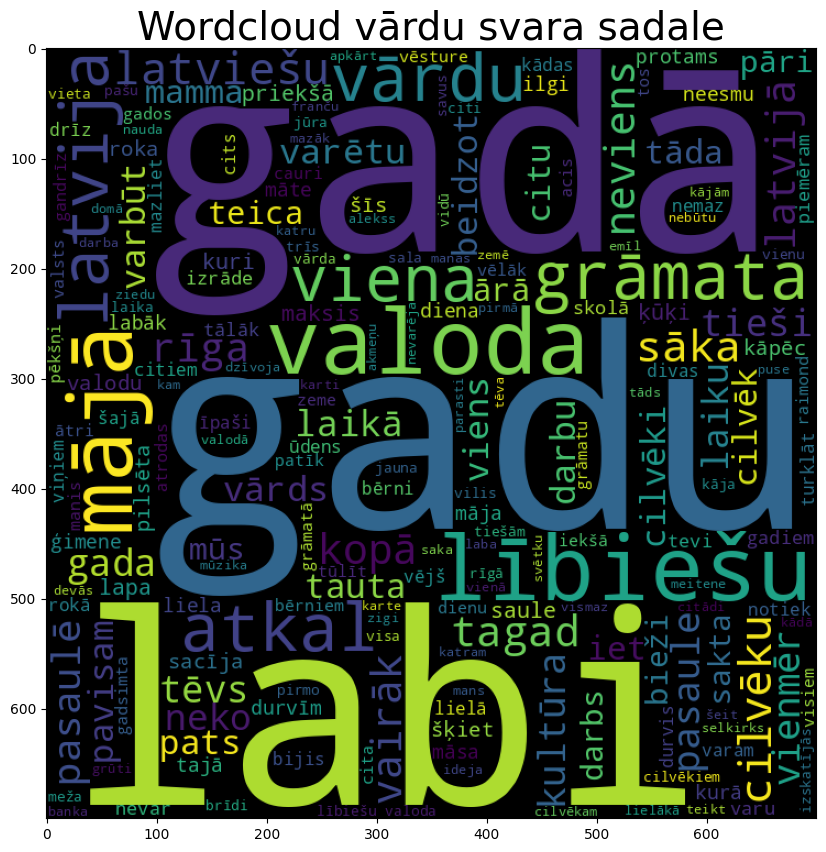

In [9]:
textplot = ''.join([str(text) for text in ProcessedText if not pd.isna(text)])

wordcloud = WordCloud(width=700, height=700).generate(textplot)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.title("Wordcloud vārdu svara sadale", fontsize=28)
plt.show()

In [52]:
def dataFeatures(df, lv_stopwords):
    num_of_words = []
    teikumu_garums = []
    vid_varda_garums = []
    teksta_garums_simb = []
    teikumu_kopskaits = []

    for text in df['Teksts'].values:

        initial_length = len(text)
        teksta_garums_simb.append(initial_length)
        teikumu_skaits = len(sent_tokenize(text))
        teikumu_kopskaits.append(teikumu_skaits)
        text = re.sub('[^a-zA-Zāčēģīķļņšūž]', ' ', text)
        text = text.lower()
        text = word_tokenize(text)
        num_words = len(text)
        num_of_words.append(num_words)
        teikumu_garums.append(num_words/teikumu_skaits)
        vid_varda_garums.append(initial_length/num_words)
        text = [word for word in text if not word in lv_stopwords]
        text = " ".join(text)
        print(text)

    df = pd.concat([pd.Series(teikumu_garums), pd.Series(num_of_words),
                             pd.Series(vid_varda_garums), pd.Series(teikumu_kopskaits), pd.Series(teksta_garums_simb)], axis = 1)
    df.columns = ["Vid. teikuma garums", "Vārdu skaits", "Vid. vārda garums",
                          "Teikumu skaits", "Teksta garums simboli"]

    return df

df['Teksts'] = df['Teksts'].astype(str).apply(lambda text: text.replace('\n', ' '))
df_train = dataFeatures(df, lv_stopwords)
# Drop NaNs from final_df
df_train.dropna(inplace=True)

ticis rīgā zaķis uzmeklē sēklu tirgotavu gudros ies iekšā prasīs kāpostu sēklas tirgotājs visas sēklas pārdevis pašlaik slauka kopā pabiras jaunskungs vēlas tirgotāju vīzei laipni noprasa kāpostu sēklas zaķis bailīgi dabū lūpu kāpostu sēklas jaunskungs vēlas galviņu kāposti rožu kāposti kacenu kāposti varbūt jaunskungs ņems kacenu kāpostus vasarā ēst lapas ziemā grauzt kacenu blēdis zaķis nodomāja visādu kāpostu sēklas piesola visgaršīgākajiem vārda citādu kāpostu sēklu jums viltīgi noprasa pārdevējs noplātīja rokas gribētu skābu kāpostu sēklas drošāk uzstājās zaķis tirgotājs pavīpsnāja šis pircējs acīm redzot galīgi zaķa
ak skābu kāpostu pavisam saldā balsī iesaucās tirgotājs dodam velti saslaucīja sēklu pabiras maisiņā pasniedza zaķim dēls bāz kabatā vasarsvētkiem iesēj jāņiem ēdīsi skābu skābos ziemassvētkus nemaz negaidīsi zaķis laimīgs brauca mājā imene iesēja kāpostus mitrajā meža liekņā zaķis pats sēdēja klāt uzmanīja putni neizkasa kurmji neizrok kazas neapgrauž sieva tos ravēj

In [44]:
df_train

,Vid. teikuma garums,Vārdu skaits,Vid. vārda garums,Teikumu skaits,Teksta garums simboli
0,8.285714,116,6.991379,14,811
1,9.800000,147,6.544218,15,962
2,7.111111,64,6.546875,9,419
3,10.400000,156,6.512821,15,1016
4,10.500000,147,7.183673,14,1056
...,...,...,...,...,...
244,9.000000,99,6.737374,11,667
245,12.500000,100,6.860000,8,686
246,10.818182,119,6.596639,11,785
247,9.307692,121,6.727273,13,814


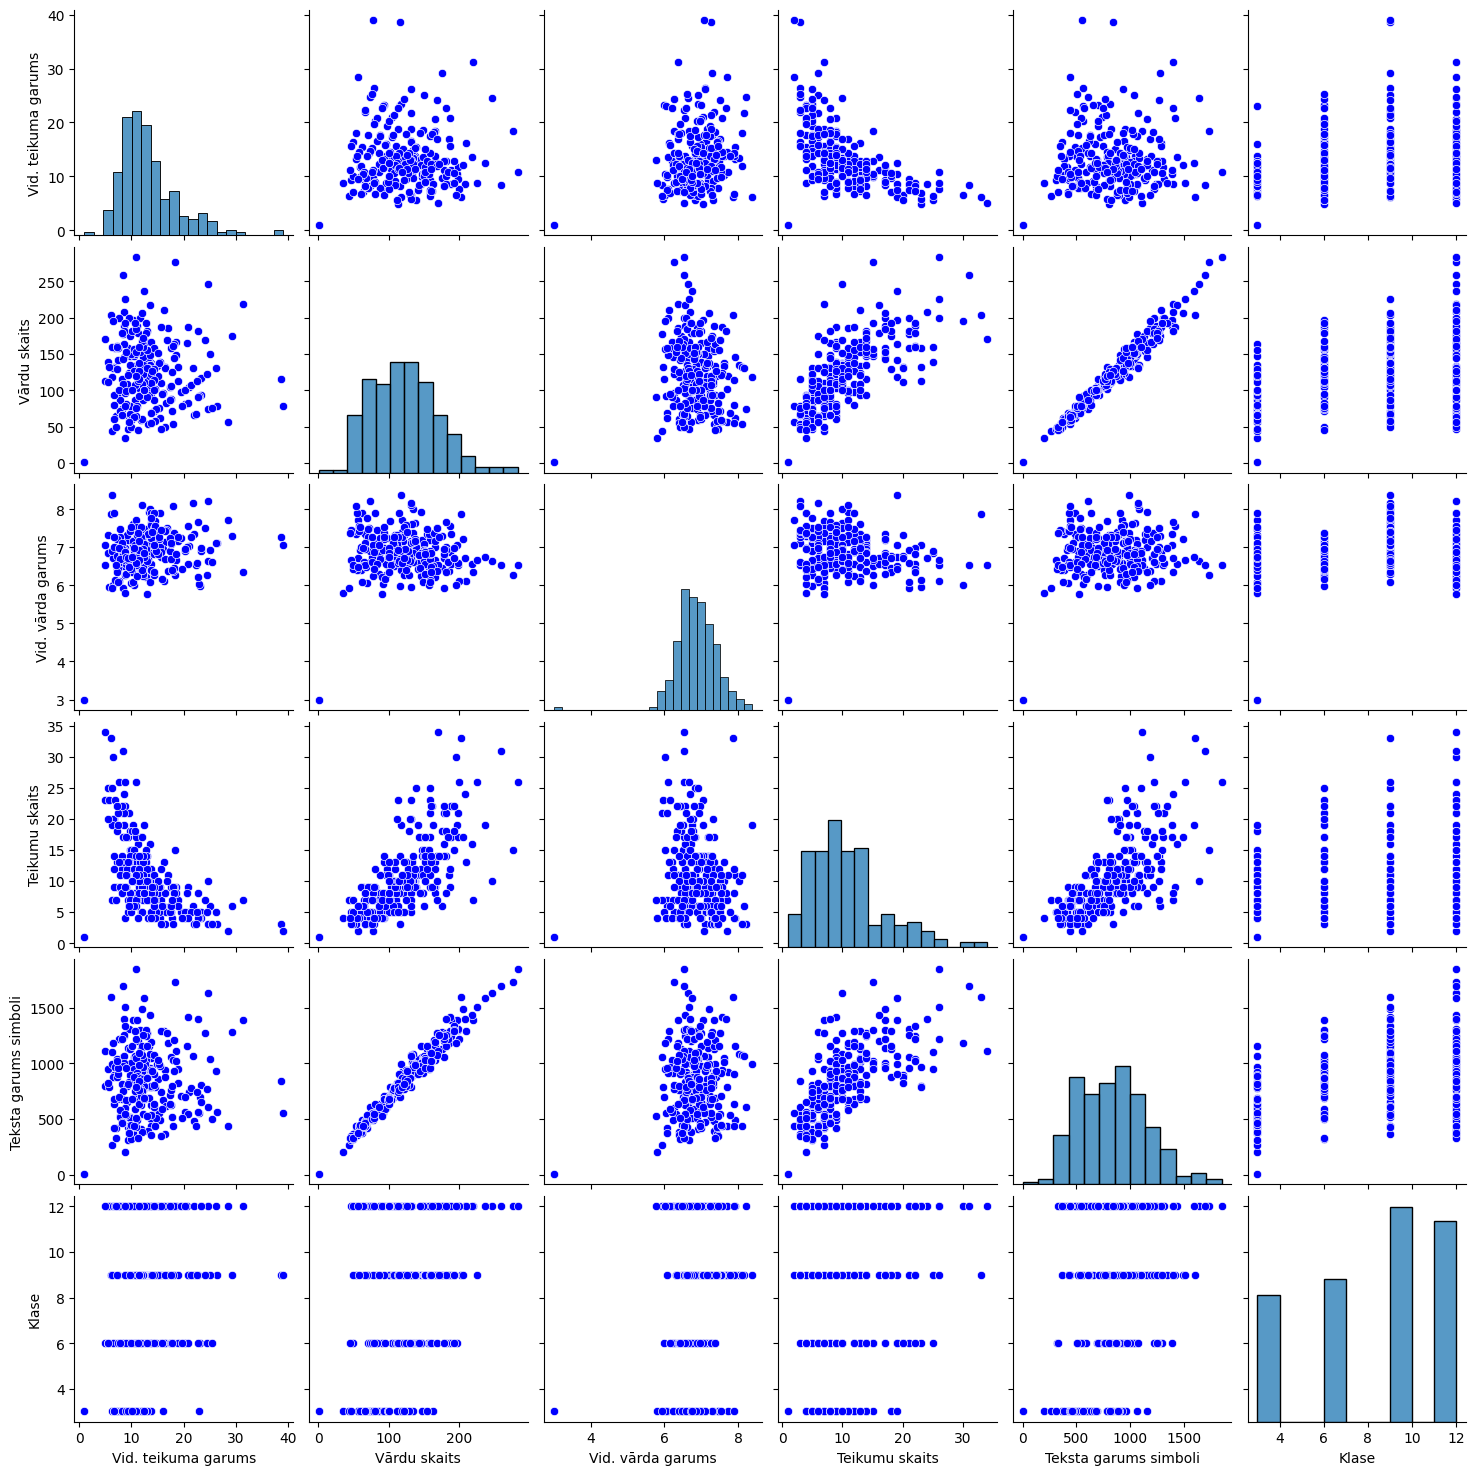

In [56]:
featurePlot = pd.concat([df_train, df['Klase']], axis = 1)
sns.pairplot(featurePlot, plot_kws = dict(color = 'blue'))
plt.show()

In [11]:
def dataPunctuationFeatures(df: pd.DataFrame):
    komati = []
    izsauksmes_zimes = []
    jautajumu_zimes = []
    tiesa_runa = []
    punkts = []
    garakais_vards = []

    for i in range(len(df)):

        text = df['Teksts'].iloc[i]
        komati.append(text.count(","))
        izsauksmes_zimes.append(text.count("!"))
        jautajumu_zimes.append(text.count("?"))
        tiesa_runa.append(text.count('„') and text.count('”'))
        punkts.append(text.count('.'))
        word_len = [len(w) for w in text.split(" ")]
        garakais_vards.append(np.max(word_len))

    df_with_features =pd.concat((pd.Series(komati), pd.Series(izsauksmes_zimes),
                               pd.Series(jautajumu_zimes), pd.Series(tiesa_runa), pd.Series(punkts),
                                pd.Series(garakais_vards)), axis = 1)
    df_with_features.columns = ["Komatu skaits", "Izsauksmes zīmju skaits",
                                "Jautājumu zīmju skaits", "Tiešu runu pēdiņas", "Punktu zīmes skaits",
                                "Garākais vārds"]
    return df_with_features

df['Teksts'] = df['Teksts'].astype(str).apply(lambda text: text.replace('\n', ' '))
df_train_extra = dataPunctuationFeatures(df)

df_train_extra

,Komatu skaits,Izsauksmes zīmju skaits,Jautājumu zīmju skaits,Tiešu runu pēdiņas,Punktu zīmes skaits,Garākais vārds
0,14,0,3,2,12,16
1,15,1,0,0,14,17
2,3,0,0,0,9,11
3,19,0,0,0,19,14
4,12,2,1,5,20,20
...,...,...,...,...,...,...
244,11,1,0,0,10,12
245,7,5,2,5,5,14
246,11,2,0,0,12,15
247,9,0,0,0,13,18


In [12]:
joined_df = pd.concat((ProcessedText, df_train, df_train_extra), axis = 1)

joined_df

,Teksts,Vid. teikuma garums,Vārdu skaits,Vid. vārda garums,Teikumu skaits,Teksta garums simboli,Komatu skaits,Izsauksmes zīmju skaits,Jautājumu zīmju skaits,Tiešu runu pēdiņas,Punktu zīmes skaits,Garākais vārds
0,ticis rīgā zaķis uzmeklē sēklu tirgotavu gudro...,8.285714,116,6.991379,14,811,14,0,3,2,12,16
1,ak skābu kāpostu pavisam saldā balsī iesaucās ...,9.800000,147,6.544218,15,962,15,1,0,0,14,17
2,lauris iziet cauri nelielam krūmājam kājas sāk...,7.111111,64,6.546875,9,419,3,0,0,0,9,11
3,andra mārītes māmiņai lādīte saktām vienīgā pi...,10.400000,156,6.512821,15,1016,19,0,0,0,19,14
4,divtūkstoš gadus kristus dzimšanas viļņu izska...,10.500000,147,7.183673,14,1056,12,2,1,5,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...
244,mazo palmiņu atnesa mājās vasaras vidū novieto...,9.000000,99,6.737374,11,667,11,1,0,0,10,12
245,brīnies ierunājās dīvainā puķe leduskaraliene ...,12.500000,100,6.860000,8,686,7,5,2,5,5,14
246,rītu logā iespīdēja spilgti saules stari ai vi...,10.818182,119,6.596639,11,785,11,2,0,0,12,15
247,cilvēka pēda maza ķermeņa karte tūkstošiem ner...,9.307692,121,6.727273,13,814,9,0,0,0,13,18


In [83]:
X = joined_df[['Teksts', 'Vid. teikuma garums', 'Vārdu skaits', 'Vid. vārda garums', 'Teikumu skaits', 'Teksta garums simboli', 'Komatu skaits', 'Izsauksmes zīmju skaits', 'Jautājumu zīmju skaits', 'Tiešu runu pēdiņas', 'Punktu zīmes skaits', 'Garākais vārds']]
y = df['Klase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

pipeline = make_pipeline(
    TfidfVectorizer(),  # Konvertē padoto normalizēto tekstu uz skaitļu datiem
    LogisticRegression()  # Izvēlētais loģistiskās regresijas modelis
)

param_grid = {
    'tfidfvectorizer__max_features': [1000, 2000, 3000],  # Kalibrē TF-IDF
    'logisticregression__C': [0.1, 1, 10],  # Pielāgo loģistiskās regresijas regularizācijas stiprumu
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train['Teksts'], y_train)

# Izvelk ārā visveikstpējīgāko GridSearchCV modeli Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

print("Visveikstpējīgāko modeļa parametri:", grid_search.best_params_)

Visveikstpējīgāko modeļa parametri: {'logisticregression__C': 10, 'tfidfvectorizer__max_features': 3000}


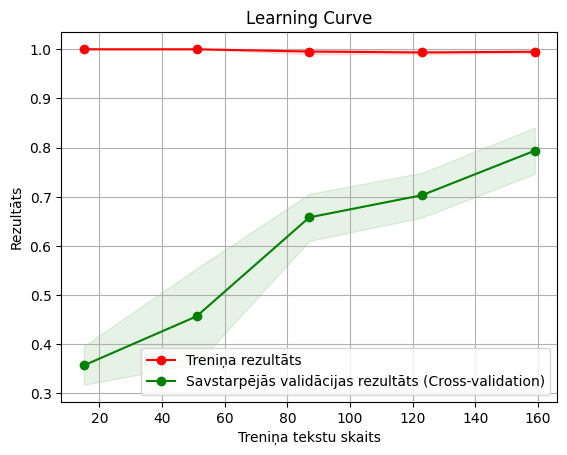

In [84]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train['Teksts'], y_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Treniņa tekstu skaits")
plt.ylabel("Rezultāts")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Treniņa rezultāts")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Savstarpējās validācijas rezultāts (Cross-validation)")

plt.legend(loc="best")
plt.show()

In [66]:
y_pred = best_model.predict(X_test['Teksts'])
accuracy = accuracy_score(y_test, y_pred)
print("Precizitāte:", accuracy)

correct_guesses = []
incorrect_guesses = []

for i in range(len(y_pred)):
    if y_pred[i] == y_test.values[i]:
        correct_guesses.append((X_test['Teksts'].iloc[i], y_test.values[i], y_pred[i]))
    else:
        incorrect_guesses.append((X_test['Teksts'].iloc[i], y_test.values[i], y_pred[i]))

print("\nPareizie minējumi:")
for text, actual, predicted in correct_guesses:
    print(f"Teksts: {text[:50]}..., Īstais: {actual}, Minējums: {predicted}")

print("\nNepareizie minējumi:")
for text, actual, predicted in incorrect_guesses:
    print(f"Teksts: {text[:50]}..., Īstais: {actual}, Minējums: {predicted}")

Precizitāte: 0.8

Pareizie minējumi:
Teksts: gada aprīlī kavalēristi vidū mūziķi studenti pasni..., Īstais: 9, Minējums: 9
Teksts: makša deguns ieelpojot alas vilinošo aromātu vēlēj..., Īstais: 6, Minējums: 6
Teksts: tagad tuvojoties durvīm kurām gaida tēvs pašā nepi..., Īstais: 12, Minējums: 12
Teksts: apmetnes stāvā kalna virsotnei selkirkam jārāpjas ..., Īstais: 9, Minējums: 9
Teksts: reiz sensenos laikos satikās trīs ceļa gājēji saul..., Īstais: 3, Minējums: 3
Teksts: dārta iekārtojas mammas dīvāna māsas kušetes spēlē..., Īstais: 12, Minējums: 12
Teksts: nepieciešams izrakt aizvest projām miljoniem kubik..., Īstais: 9, Minējums: 9
Teksts: karsta gada aprīļa diena sapulcējušies ļaudis raug..., Īstais: 9, Minējums: 9
Teksts: mūzika neapšaubāmi agresīva uzbrūkoša iekšā ievelk..., Īstais: 12, Minējums: 12
Teksts: romāna cilvēka bērns autora jāņa klīdzēja bērnības..., Īstais: 9, Minējums: 9
Teksts: aleksam bastijam māsīca uzburta brīvprātīgo darbu ..., Īstais: 6, Minējums: 6
Teksts: ēda

In [80]:
# Daži īstās dzīves piemēri

# 'Bermudu Divstūru' dziesmas lirikas, https://genius.com/Bermudu-divsturis-roku-okeans-lyrics
y_pred = best_model.predict(['Dienā, kad nespīd vairāk saule un naktīs zvaigžņu nav, nav naktīs zvaigžņu nav, nav. Iesim, ielās tad mēs iesim, lai atkal zvaigžņu daudz daudz.'])
print("Minējums klasei:"y_pred)

# lsm raksts par Grieķijas plūdiem, https://www.lsm.lv/raksts/zinas/arzemes/14.04.2024-griekija-atkopsanas-pec-pludiem-rosina-diskusijas-par-lauksaimniecibas-nakotni.a549747/
y_pred = best_model.predict(['Grieķijas iestādes nav norādījušas plūdu skartā reģiona atkopšanās grafiku, un pastāv pretrunīgi viedokļi par turpmāko rīcību. Tesālijas iestādes atbalsta liela kanāla rakšanu.'])
print(y_pred)

# lsm raksts par cilvēka atpūtu, https://www.lsm.lv/raksts/dzive--stils/ikdienai/14.04.2024-ka-labak-atpusties-skaidro-kliniska-psihologe-marija-abeltina.a549316/
y_pred = best_model.predict(['"Tas, ko pētnieki saka, un ko arī praksē mēs varam novērot, ir, ka nav jau tā, ka katrs atvaļinājums un katra atpūtas dienai vai piektdienas vakars ir atpūtinošs.'])
print(y_pred)

[3]
[9]
[12]


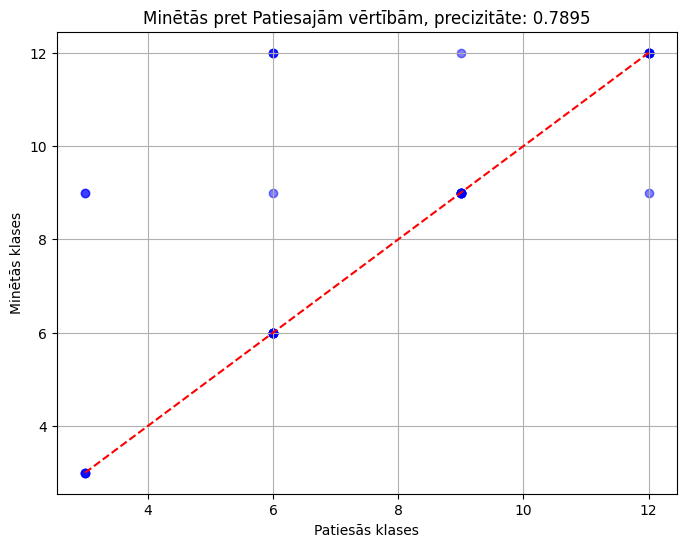

In [40]:
y_actual = y_test.values
y_predicted = y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_predicted, color='blue', alpha=0.5)

plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

plt.title('Minētās pret Patiesajām vērtībām, precizitāte: '+str(round(accuracy, 4)))
plt.xlabel('Patiesās klases')
plt.ylabel('Minētās klases')
plt.grid(True)
plt.show()

In [85]:
joblib.dump(best_model, 'best_model.pkl')
files.download('best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>